# Diffusion Generative Modelling for Simulation-Based Inference

An introduction to diffusion generative models in SBI to learn and sample from posterior distributions in the setiing of tall context data. 

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import torch
torch.manual_seed(0)

import sys
sys.path.append("../")

N_TRAIN = 10_000
N_SAMPLES = 4096

## SBI Task: Simulator, Prior and True/Target Posterior 

- Prior (2D): $p(\theta) = \mathcal{U}([-10,10]^2)$
- Simualtor (2D): $x \sim \text{Simulator}(\theta) \approx p(x\mid \theta) = \mathcal{N}(\theta, \Sigma)$ with $\Sigma = \begin{pmatrix} 1 & 0.8 \\ 0.8 & 1 \end{pmatrix}$

Goal: estimate $p(\theta\mid x_0)$ with $x_0$ an observation.

In [2]:
# SBI Task: Inference of 2d Gaussian Mean under uniform prior
from sbi.utils import BoxUniform
from tasks.toy_examples.data_generators import SBIGaussian2d
from tasks.toy_examples.prior import ToyPrior

# Task
task = SBIGaussian2d(prior=ToyPrior())
# Prior and Simulator
prior = task.prior
simulator = task.simulator

# Observation
theta_true = torch.FloatTensor([-5, 150])  # true parameters
x_obs = simulator(theta_true)  # x_0 ~ simulator(theta_true)
observation = {"theta_true": theta_true, "x_obs": x_obs}

# True posterior: P(theta|x_0)
true_posterior = task.true_posterior(x_obs)


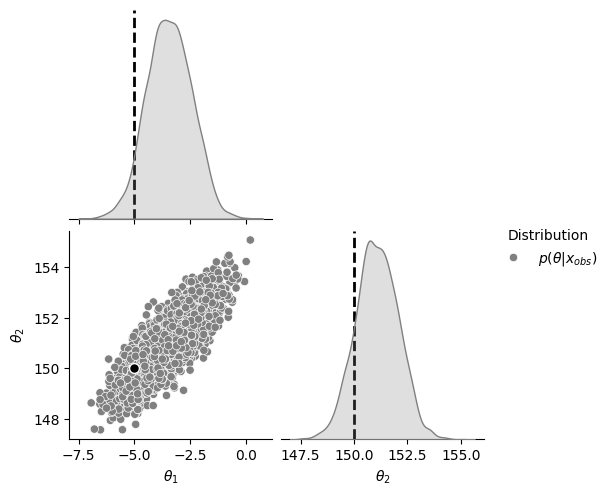

In [3]:
# Plot True posterior: P(theta | x_obs)

from plot_utils import pairplot_with_groundtruth_2d

samples_true = true_posterior.sample((N_SAMPLES,)).numpy()

pg = pairplot_with_groundtruth_2d(
    samples_list=[samples_true],
    labels=[r"$p(\theta | x_{obs})$"],
    colors=["grey"],
    theta_true=theta_true,
    # prior_bounds=(prior.bounds[0], prior.bounds[1])
)


The simulator is stochastic, meaning that a generated observation `x_obs` might not correspond to the most probable one. In this case, the posterior $p(\theta \mid x_0) = \mathcal{N}(x_0, \Sigma)$ is centered around $x_0$=`x_obs` and not $\theta_0$=`theta_true`.

Indeed: $p(\theta \mid x_0) = p(x_0\mid \theta)p(\theta)/p(x_0) = p(x_0\mid \theta)$ because $p(\theta) \sim \mathcal{U}(0,1)$ is uniform. Finally we have that $p(\theta \mid x_0) = p(x_0\mid \theta) =p_{\mathcal{N}(\theta, \Sigma)}(x_0) = p_{\mathcal{N}(x_0, \Sigma)}(\theta) = \mathcal{N}(x_0, \Sigma)$ because of the symmetry of the gaussian distribution.

In order to solve this stochasticity problem and get a posterior centered around the true parameters `theta_true` (i.e. that generated `x_obs`), we would need more than one observation simulated using the true parameter $\theta_0$ to get an empirical approximation of the mean of the simulator likelihood:
$$x_i \sim p(x\mid \theta_0) = \mathcal{N}(\theta_0,\Sigma) \rightarrow x_{mean} = \frac{1}{n}\sum x_i \approx \theta_0$$

So $p(\theta \mid x_{mean}) \approx p(\theta \mid \theta_0) =\mathcal{N}(\theta_0, \Sigma)$.



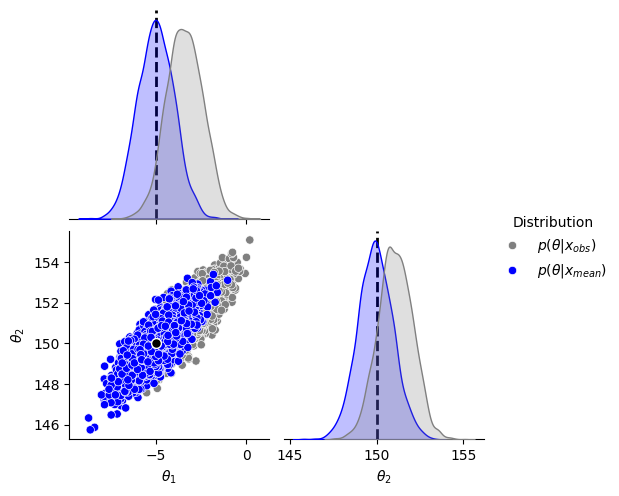

In [4]:
# Plot p(theta|mean(x_1,...,x_10)), x_i ~ simulator(theta_true)

x_obs_100 = torch.cat([simulator(theta_true).reshape(1, -1) for i in range(100)], dim=0)
true_posterior_100 = task.true_posterior(torch.mean(x_obs_100, axis=0))
samples_true_100 = true_posterior_100.sample((N_SAMPLES,)).numpy()

pairplot_with_groundtruth_2d(
    samples_list=[samples_true, samples_true_100],
    labels=[r"$p(\theta | x_{obs})$", r"$p(\theta | x_{mean})$"],
    colors=["grey", "blue"],
    theta_true=theta_true,
    # prior_bounds=(prior.bounds[0], prior.bounds[1])
)


## Posterior Estimation via Score-Matching
In what follows, the estimator will try to approximate the posterior $p(\theta \mid x_0) = \mathcal{N}(x_0, \Sigma)$ with samples from the joint $(x_i, \theta_i) \sim p(x\mid \theta_i)p(\theta_i)$ using score-matching.

See [[Sharrock et al. (2022)]](https://arxiv.org/abs/2210.04872).

### Data Generation

In [5]:
# Train data
theta_train, x_train = task.get_joint_data(N_TRAIN)

# normalize theta
theta_train_ = (theta_train - theta_train.mean(axis=0)) / theta_train.std(axis=0)

# normalize x
x_train_ = (x_train - x_train.mean(axis=0)) / x_train.std(axis=0)
x_obs_ = (x_obs - x_train.mean(axis=0)) / x_train.std(axis=0)
x_obs_100_ = (x_obs_100 - x_train.mean(axis=0)) / x_train.std(axis=0)


### Neural Posterior Score Estimation (NPSE)

Training the score model consists in minimizing the DSM loss, i.e. the expectation over the uniformly distributed time frame in $[0,T]$ of the weighted DSM losses. 
$$\mathcal{L}^{\mathrm{DSM}}(\phi) = \mathbb{E}_{\mathcal{U}(0,T)} \Big[\lambda_t \mathcal{L}^{\mathrm{DSM}_t}(p_t, \phi)\Big]$$

We are in a conditional case, the DSM losses depend on data from the joint distribution $p(\theta,x)$ and the score model $s_\phi(\theta,x,t)$ depends on the context varaible $x$, in addition to the target varaible $\theta$ and the time variable $t$: 

$$ \mathcal{L}^{\mathrm{DSM}_t}(p_t,\phi) = \mathbb{E}_{p_{t\mid0}(\theta(t)|\theta(0)), p(\theta(0),x)}\left[||s_{\phi}(\theta(t),x, t)-\nabla_\theta \log p_{t\mid0}(\theta(t)\mid \theta(0))||^2\right]$$

> Note that only the target variable $\theta$ is diffused via the SDE forward transition kernel $p_{t0}(\theta(t)\mid \theta(0))$ and $\theta(0) \sim p(\theta), x \sim p(x\mid \theta(0))$ are data from the joint.

#### Define and train Score Model

In [6]:
# score_network
from nse import NSE, NSELoss
from sm_utils import train

# torch.set_default_device("cuda:0")
dataset = torch.utils.data.TensorDataset(theta_train_.cuda(), x_train_.cuda())
score_net = NSE(theta_dim=2, x_dim=2, hidden_features=[128, 256, 128]).cuda()



In [7]:
avg_score_net = train(
    model=score_net,
    dataset=dataset,
    loss_fn=NSELoss(score_net),
    n_epochs=200,
    lr=1e-3,
    batch_size=256,
    prior_score=False, # learn the prior score via the classifier-free guidance approach
)
score_net = avg_score_net.module

Training epochs: 100%|██████████| 200/200 [00:50<00:00,  3.92it/s, loss=0.0353]


#### Sample from the approximate posterior

In [8]:
# sample from the appeoximate posterior
samples_npse = score_net.ddim((N_SAMPLES,), x=x_obs_.cuda(), steps=256).detach().cpu()
# # unnormalize samples
samples_npse = samples_npse * theta_train.std(axis=0) + theta_train.mean(axis=0)

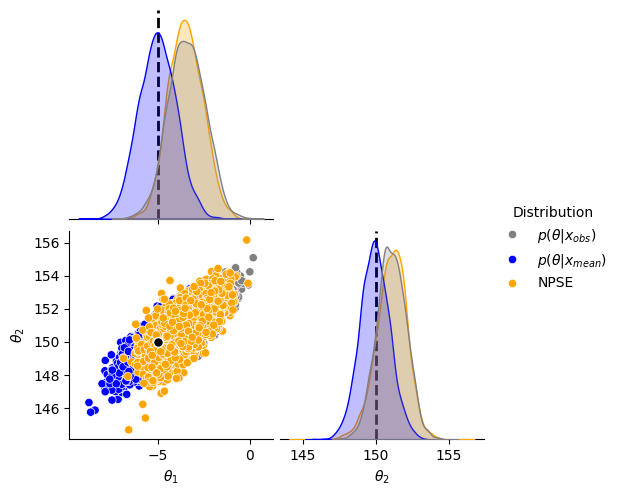

In [9]:
# Plot True vs. learned posteriors: P(theta | x_obs)
samples_list=[samples_true, samples_true_100, samples_npse]

pairplot_with_groundtruth_2d(
    samples_list=samples_list,
    labels=[r"$p(\theta | x_{obs})$", r"$p(\theta | x_{mean})$", "NPSE"],
    colors=["grey", "blue", "orange"],
    theta_true=theta_true
)


## Aggregated score by Tweedie's

### Replacing our approximation in the Langevin scheme

Below, we test replacing the F-NPSE score with our new version that incorporates the correction term L.


In [10]:
from vp_diffused_priors import get_vpdiff_uniform_score

low_ = (prior.low - theta_train.mean(axis=0)) / theta_train.std(axis=0)
high_ = (prior.high - theta_train.mean(axis=0)) / theta_train.std(axis=0)

diffused_prior_score = get_vpdiff_uniform_score(low_.cuda(), high_.cuda(), nse=score_net)

# # try with learned prior score
# diffused_prior_score = lambda theta,t: score_net.score(theta=theta, x=torch.zeros_like(x_obs_100[:10]).cuda(), t=t)

#### Analyzing the correction term `L`

**ATTENTION**: Higher amounts of added correction term `L` still give erronated results (see below). Maybe better with learned prior (out-of distribution sampling effects)? 

In [11]:
samples_per_correction = {}
for correction_lda in [0, 1e-2, 1e-1, 3e-1, 5e-1]: # amount of correction term L in addition to the original F-NPSE
    samples_langevin_ = score_net.predictor_corrector((N_SAMPLES,),
                                                      x=x_obs_100_[:10].cuda(),
                                                      steps=400,
                                                      prior_score_fun=diffused_prior_score,
                                                      eta=0.01,
                                                      corrector_lda=correction_lda,
                                                      n_steps=5,
                                                      r=.5,
                                                      predictor_type='ddim',
                                                      verbose=True).cpu()
    samples_per_correction[correction_lda] = samples_langevin_ * theta_train.std(axis=0) + theta_train.mean(axis=0)

  0%|          | 0/400 [00:00<?, ?it/s]

100%|██████████| 400/400 [02:23<00:00,  2.78it/s]


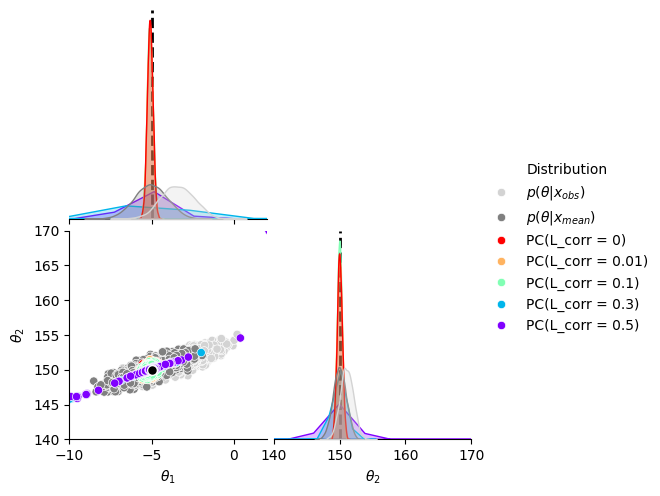

In [ ]:
from matplotlib import colormaps as cm
samples_true_mean = task.true_posterior(torch.mean(x_obs_100[:10], axis=0)).sample((N_SAMPLES,)).numpy()
pairplot_with_groundtruth_2d(
    samples_list=[samples_true,  samples_true_mean] + list(samples_per_correction.values()),
    labels=[r"$p(\theta | x_{obs})$", r"$p(\theta | x_{mean})$"]+[f"PC(L_corr = {k})" for k in samples_per_correction],
    colors=["lightgray", "gray"] + [cm.get_cmap("rainbow")(i) for i in torch.linspace(1, 0, len(samples_per_correction)).cpu()],
    theta_true=theta_true,
    # prior_bounds=(prior.bounds[0], prior.bounds[1]),
    plot_bounds=([-10, 2], [140, 170]),
)

#### Analyzing the Langevin corrector
PC sampling with `predictor_type='id'` is Langevin Dynamics without predictior. When `predictor_type='ddim'`, the sde solver is used. The goal is to be able to use it without any langevin correction (`n_steps=0`).

1. We verify if we can recover the original F-NPSE results with our code (`predictor_type='id', 'correction_lda=0'`).
2. We check how many langevin steps are needed to get good results with the `ddim` predictor when a small correction term L is considered `correction_lda=0.01`.

**ATTENTION**: `n_steps=0` gives very sharp possibly biased posterior approximations (see below). 

In [12]:
samples_per_predictor = {}
for predictor, n_steps, correction_lda in zip(['id', 'ddim', 'ddim', 'ddim', 'ddim','ddim'], [5, 5, 2, 1, 0, 0], [0, 0.01, 0.01, 0.01, 0.01, 0]): 
    samples_langevin_ = score_net.predictor_corrector((N_SAMPLES,),
                                                      x=x_obs_100_[:10].cuda(),
                                                      steps=400,
                                                      prior_score_fun=diffused_prior_score,
                                                      eta=0.01,
                                                      corrector_lda=0.1,
                                                      n_steps=n_steps,
                                                      r=.5,
                                                      predictor_type=predictor,
                                                      verbose=True).cpu()
    samples_per_predictor[predictor+f", n-steps={n_steps}"] = samples_langevin_ * theta_train.std(axis=0) + theta_train.mean(axis=0)

  0%|          | 0/400 [00:00<?, ?it/s]

100%|██████████| 400/400 [00:24<00:00, 16.48it/s]


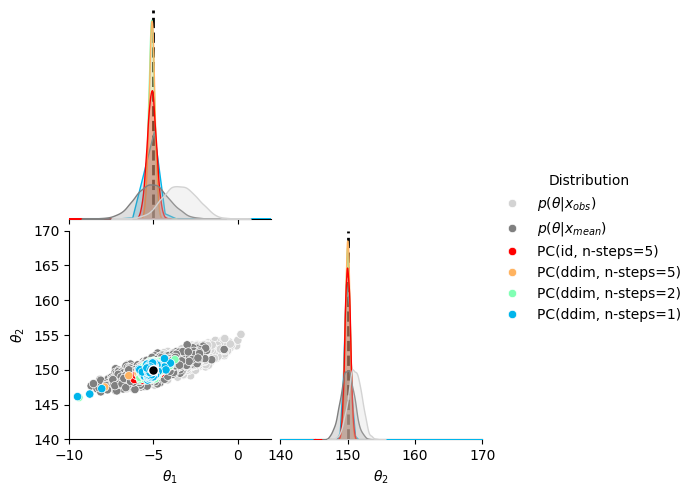

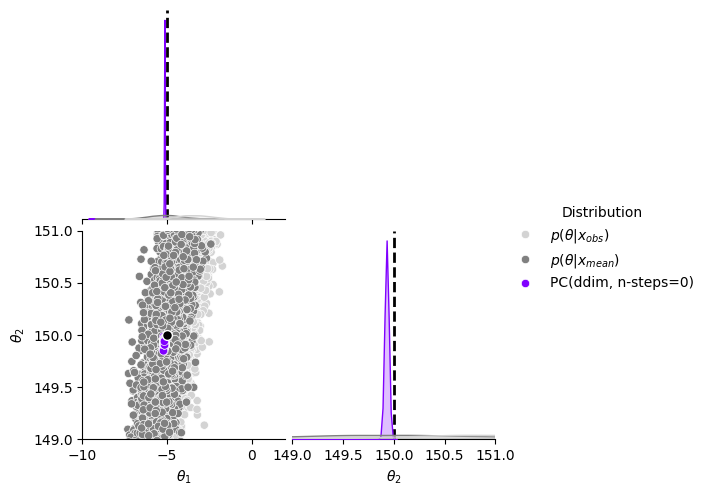

In [46]:
from matplotlib import colormaps as cm
samples_true_mean = task.true_posterior(torch.mean(x_obs_100[:10], axis=0)).sample((N_SAMPLES,)).numpy()

pairplot_with_groundtruth_2d(
    samples_list=[samples_true,  samples_true_mean] + list(samples_per_predictor.values())[:4],
    labels=[r"$p(\theta | x_{obs})$", r"$p(\theta | x_{mean})$"]+[f"PC({k})" for k in samples_per_predictor][:4],
    colors=["lightgray", "gray"] + [cm.get_cmap("rainbow")(i) for i in torch.linspace(1, 0, len(samples_per_predictor)).cpu()][:4],
    theta_true=theta_true,
    # prior_bounds=(prior.bounds[0], prior.bounds[1]),
    plot_bounds=([-10, 2], [140, 170]),
)

pairplot_with_groundtruth_2d(
    samples_list=[samples_true,  samples_true_mean] + list(samples_per_predictor.values())[4:5],
    labels=[r"$p(\theta | x_{obs})$", r"$p(\theta | x_{mean})$"]+[f"PC({k})" for k in samples_per_predictor][4:5],
    colors=["lightgray", "gray"] + [cm.get_cmap("rainbow")(i) for i in torch.linspace(1, 0, len(samples_per_predictor)).cpu()][4:5],
    theta_true=theta_true,
    # prior_bounds=(prior.bounds[0], prior.bounds[1]),
    plot_bounds=([-10, 2], [149, 151]),
)

### Factorized Neural Posterior Score Estimation (F-NPSE)

See [[Geffner et al. (2023)]](https://arxiv.org/abs/2209.14249).

This method allows to infer the posterior $p(\theta \mid c)$ conditioned on several observations $c = \{x_1, \dots, x_n\}$ **without having to retrain the posterior score-model** (previously obtained for one conditionning observation):

1. Train the posterior score model $s_\phi(\theta,x,t)$ with the *annealed langevin ISM loss* for one condtionning observation

2. Sample via annealed langevin dynamics, but with the factorized posterior score defined as follows:
$$ s_{\phi}^{f}(\theta, c, t) = (1-n)\nabla_\theta \log p_t(\theta) + \sum_{i=1}^n s_\phi(\theta, x_i, t)$$

> $n$ is the number of conditionning observations at inference time

> The score of the diffused prior $p_t(\theta)$ is learned or analytically computed

In [ ]:
# F-NPSE
def factorized_posterior_score(
    theta: torch.Tensor,  # (nsamples, dim_theta)
    xs_context: torch.Tensor,  # (n, dim_x)
    t: torch.Tensor,  # (nsamples, 1)
    posterior_score: callable,
    prior_score: callable,
    diffused_prior: bool = True,
    tsteps: int = 5,
) -> torch.Tensor:
    n = xs_context.shape[0]

    aggregated_posterior_score = torch.stack(
        [
            posterior_score(
                theta,
                x_c,  # .unsqueeze(1),  # (dim_x)
                t,
            )
            for x_c in xs_context
        ]
    )  # (n, nsamples, dim_theta)

    aggregated_posterior_score = torch.sum(
        aggregated_posterior_score, axis=0
    )  # (nsamples, dim_theta)

    if diffused_prior:
        normalized_prior_score = prior_score(theta, t=t) * (1 - n)
    else:
        normalized_prior_score = prior_score(theta) * (1 - n) * (tsteps - t) / tsteps

    return (
        normalized_prior_score + aggregated_posterior_score
    ) / - posterior_score.sigma(t)


# Annealed Langevin Sampling
from torch import Tensor, Size
from tqdm import tqdm

def annealed_langevin(
        score_fn,
        shape: Size,
        x: Tensor,
        steps: int = 64,
        lsteps: int = 1000,
        tau: float = 1,
        verbose: bool = False,
        **kwargs,
    ):
        time = torch.linspace(1, 0, steps + 1).to(x)

        theta = torch.randn(shape).to(x)

        for t in tqdm(time[:-1], disable=not verbose):
            for _ in range(lsteps):
                z = torch.randn_like(theta)
                score =  score_fn(theta, x, t, **kwargs).detach()
                delta = tau / score.square().mean()
                theta = (
                    theta
                    + delta * score
                    + torch.sqrt(2 * delta) * z
                )

        return theta


In [ ]:
# anneled langevin sampling from the approximate posterior p(theta | x_obs)
torch.set_default_device("cuda:0")
score_net.to("cuda:0")
score_fn = lambda theta, x, t: score_net(theta, x, t) / - score_net.sigma(t)
with torch.no_grad():
    samples_npse = score_net.annealed_langevin(
        (N_SAMPLES,),
        x=x_obs_.cuda(),
        steps=400,
        lsteps=5,
        tau=0.5,
        verbose=True,
    ).detach()

# unnormalize samples
samples_npse = (samples_npse * theta_train.std(axis=0).cuda() + theta_train.mean(axis=0).cuda()).cpu()


In [ ]:
# sample from the approximate posterior p(theta | x_1, ..., x_10)
from functools import partial
from copy import deepcopy

prior_score_network = deepcopy(score_net)
prior_score = partial(
    prior_score_network,
    x=torch.zeros((N_SAMPLES, x_obs.shape[-1])),
)
kwargs_score_fn = {
    "posterior_score": score_net,
    "prior_score": prior_score,
    "diffused_prior": True,
}
with torch.no_grad():
    samples_fnpse_10 = annealed_langevin(
        score_fn=partial(factorized_posterior_score, tsteps=400),
        shape=(N_SAMPLES,2),
        x=x_obs_100_[:10].cuda(),
        steps=400,
        lsteps=5,
        tau=0.5,
        verbose=True,
        **kwargs_score_fn,
    )

# unnormalize samples
samples_fnpse_10 = (samples_fnpse_10 * theta_train.std(axis=0).cuda() + theta_train.mean(axis=0).cuda()).cpu()


In [ ]:
kwargs_score_fn = {
    "posterior_score": score_net,
    "prior_score": lambda theta, t: - diffused_prior_score(theta, t) * score_net.sigma(t),
    "diffused_prior": True,
}

with torch.no_grad():
    samples_fnpse_ana_10 = annealed_langevin(
        score_fn=partial(factorized_posterior_score, tsteps=400),
        shape=(N_SAMPLES,2),
        x=x_obs_100_[:10].cuda(),
        steps=400,
        lsteps=5,
        tau=0.5,
        verbose=True,
        **kwargs_score_fn,
    )

# unnormalize samples
samples_fnpse_ana_10 = (samples_fnpse_ana_10 * theta_train.std(axis=0).cuda() + theta_train.mean(axis=0).cuda()).cpu()


In [ ]:
# Plot True vs. learned posteriors:
from matplotlib import colormaps as cm

samples_list=[samples_true, samples_true_100, samples_npse, ours_ests[10], samples_fnpse_10, samples_fnpse_10]

pairplot_with_groundtruth_2d(
    samples_list=samples_list,
    labels=[r"$p(\theta | x_{obs})$", r"$p(\theta | x_{mean})$", "NPSE", "ours(10)", "F-NPSE (n=10)", "F-NPSE-A (n=10)"],
    colors=["grey", "black"] + [cm.get_cmap("rainbow")(i) for i in torch.linspace(0.8, 0, 4).cpu()],
    theta_true=theta_true,
    plot_bounds=([-10, 2], [140, 160]),
)


In [ ]:
samples_fnpse_10

### Partially Factorized NPSE (PF-NPSE)

#### Motivation

**`F-NPSE` vs. `NPSE` with context *SETS* of arbitrary size**. In order to estimate the posterior $p(\theta \mid c)$ conditionned on multiple i.i.d. data points $c = \{x^1, \dots, x^n\} \sim p(x\mid \theta)$, the naive version would be to change the architecture of `NPSE` to take as input a sets of context points $X = \{x^j\}_j$ instead of a single context point $x$, and aggregate the elements $x^j$ (after optional embedding) via a permutation-invariant function (e.g. the mean). The resulting aggregated vector can then be passed to the score network, which takes an additional input, the set size $n$:

$$s_\phi(\theta, c, t, n) = s_\phi(\theta, \frac{1}{n}\sum_{j=1}^n x^j, t, n) \approx \nabla_\theta \log p_t(\theta \mid x^1, \dots, x^n)$$

The loss function is therefore changed by adding an expectation over $n$ and the training data is sampled as follows:

$$(n_i, \theta_i, X_{n_i}) ∼ U(0, n_{max})p(\theta)p(X \mid \theta,n) \quad \text{with} \quad X_{n_i} = \{x_i^1, \dots x_i^{n_i}\}$$

where  $p(X\mid \theta,n) = p(X_n \mid \theta) = \prod_{j=1}^n p(x^j\mid \theta)$, because the $x^j$ are i.i.d.

**Drawbacks:**
- Does not allow to infer for an arbitrary number of conditionning observations: requires $n_{max}$ to be specified
- Simulation costly: for every sample $\theta$ we need to simulate $n$ data points $x_i$ ($n_{max}/2$ calls on average during training)

**Advantage:**
- Less approximation error than F-NPSE: no summing of estimated scores (no error accumulation)

**`PF-NPSE`: best of both worlds.** To infer the posterior conditioned on a set $c = \{x^1, \dots, x^n\}$ of $n$ data points, $n$ being any integer, `PF-NPSE` operates like `F-NPSE`, but instead of factorizing scores conditioned on a single context variable, it factorizes scores conditioned on a subset $X_l$ of $l<n$ data points:

$$s_\phi^{pf}(\theta, c, t) = (1-n)\nabla_\theta \log p_t(\theta) + \sum_{j=1}^k s_\phi(\theta, X_{l_j}, t, l_j)$$

1. Define a maximum subset size $m$

2. Train `NPSE` to be able to infer posterior scores conditioned on sets $X_l$ of size $l \in [1,m]$

3. Apply `F-NPSE` on the subsets obtained by partitionning $c$ into $k$ subsets $\{X_{l_1}, \dots X_{l_k}\}$ of maximum size $m$, i.e. $l_j \in [1,m], \forall j \in [1,k]$.


Best of both worlds:
- More simulation efficient than `NPSE`: $m/2$ simulator calls
- Less error accumulation than in `F-NPSE`: only $k = n//m < n$ estimated scores are summed and contribute to the approximation error


### Data Generation with variable set size `n`

In [ ]:
# Simulate Data, create dataset with variable n
from tqdm import tqdm

N_train = 10_000
n_max = 10

theta_train = prior.sample((N_train,))
n_train = torch.randint(1, n_max+1, size=(N_train,1))
x_train = []
for theta, n in tqdm(zip(theta_train, n_train)):
    xs = []
    for _ in range(n):
        xs.append(simulator(theta))
    for _ in range(n_max-n):
        xs.append(torch.zeros_like(xs[-1]))
    xs = torch.stack(xs)
    x_train.append(xs)
x_train = torch.stack(x_train)


In [ ]:
# normalize theta
theta_train_ = (theta_train - theta_train.mean(axis=0)) / theta_train.std(axis=0)

# normalize x
x_mean = x_train[x_train != 0].reshape(-1,2).mean(axis=0)
x_std = x_train[x_train != 0].reshape(-1,2).std(axis=0)
x_train_ = ((x_train - x_mean) / x_std) * (x_train != 0)
x_obs_ = (x_obs - x_mean) / x_std
x_obs_100_ = (x_obs_100 - x_mean) / x_std

In [ ]:
from pf_npse import PF_NPSE
from zuko.nn import MLP
from sm_utils import train

# try embedding and masking
embedding_nn_theta = MLP(2, 8, hidden_features=[8])
embedding_nn_x = MLP(2, 8, hidden_features=[8])

# define model
score_net_nmax_10 = PF_NPSE(
    theta_dim=2,
    x_dim=2,
    n_max = n_max,
    embedding_nn_theta=embedding_nn_theta,
    embedding_nn_x=embedding_nn_x,
    hidden_features=[256, 256],
)

# define dataloader
data_nmax_10 = torch.utils.data.TensorDataset(theta_train_, x_train_, n_train)

# train model
train(
    model=score_net_nmax_10,
    dataset=data_nmax_10,
    loss_fn=NSELoss(score_net_nmax_10),
    n_epochs=1024,
    batch_size=256,
    lr=1e-3,
    prior_score=True,
)


In [ ]:
# 1 ( < n_max) context observation

samples = score_net_nmax_10.ddim(
    (N_SAMPLES,),
    x=x_obs_,
    n=torch.ones(1,),
    steps=256,
    verbose=True,
).detach()

# unnormalize samples
samples = samples * theta_train.std(axis=0) + theta_train.mean(axis=0)


In [ ]:
# 5 (< n_max) context observations

samples_5 = score_net_nmax_10.ddim(
    (N_SAMPLES,),
    x=x_obs_100_[:10],
    n=torch.ones(1,) * 5,
    steps=256,
    verbose=True,
).detach()

# unnormalize samples
samples_5 = samples_5 * theta_train.std(axis=0) + theta_train.mean(axis=0)

In [ ]:
# 10 (= n_max) context observations

samples_10 = score_net_nmax_10.ddim(
    (N_SAMPLES,),
    x=x_obs_100_[:10],
    n=torch.ones(1,) * n_max,
    steps=256,
    verbose=True,
).detach()

# unnormalize samples
samples_10 = samples_10 * theta_train.std(axis=0) + theta_train.mean(axis=0)

In [ ]:
# Plot True vs. learned posteriors:
from matplotlib import colormaps as cm

samples_list = [samples_true, samples_true_100, samples_npse, samples_5, samples_10]

pairplot_with_groundtruth_2d(
    samples_list=samples_list,
    labels=[
        r"$p(\theta | x_{obs})$",
        r"$p(\theta | x_{mean})$",
        "NPSE (n=1)",
        "NPSE (n=5)",
        "NPSE (n=10)",
    ],
    colors=["grey", "black"]
    + [cm.get_cmap("Oranges")(i) for i in torch.linspace(0.4, 0.8, 3)],
    theta_true=theta_true,
)


In [ ]:
# PF-NPSE
def partially_factorized_posterior_score(
    theta: torch.Tensor,  # (nsamples, dim_theta)
    xs_context: torch.Tensor,  # (n, dim_x)
    t: torch.Tensor,  # (nsamples, 1)
    n_max: int,
    posterior_score: callable,
    prior_score: callable,
    diffused_prior: bool = True,
    tsteps: int = 1000,
) -> torch.Tensor:
    n = xs_context.shape[0]  # total number of context points
    k = n // n_max  # number of full subsets of size n_max
    r = n % n_max  # number of remaining context points

    # list of k subsets of size (nsamples, n_max, dim_x)
    idx_list = [torch.arange(i * n_max, (i + 1) * n_max) for i in range(k)]
    xs_context_sub = [xs_context[idx, :] for idx in idx_list]
    ns = [torch.ones((1,)).to(theta) * n_max for i in range(k)]

    # append remaining subset of size (nsamples, r, dim_x)
    if r > 0:
        x_c_sub = torch.cat(
            (
                xs_context[[torch.arange(n - r, r)], :],
                torch.zeros((n_max - r, xs_context_sub.shape[-1])).to(theta),
            ),
            dim=1,
        )
        xs_context_sub.append(x_c_sub)
        ns.append(torch.ones((1,)).to(theta) * r)

    # calculate the posterior score for each element subset
    aggregated_posterior_score = torch.stack(
        [posterior_score(theta, x_c, t, n) for x_c, n in zip(xs_context_sub, ns)]
    )

    aggregated_posterior_score = torch.sum(aggregated_posterior_score, axis=0)
    if diffused_prior:
        normalized_prior_score = prior_score(theta, t=t) * (1 - k)
    else:
        normalized_prior_score = prior_score(theta) * (1 - k) * (tsteps - t) / tsteps

    return (
        normalized_prior_score + aggregated_posterior_score
    ) / -posterior_score.sigma(t)

In [ ]:
from functools import partial
from copy import deepcopy

prior_score_network_nmax_10 = deepcopy(score_net_nmax_10)
prior_score = partial(
    prior_score_network_nmax_10,
    x=torch.zeros((N_SAMPLES, n_max, x_obs_.shape[-1])),
    n=torch.zeros((N_SAMPLES, 1)),
)

kwargs_score_fn = {
    "posterior_score": score_net_nmax_10,
    "prior_score": prior_score,
    "diffused_prior": True,
    "n_max": n_max,
}

with torch.no_grad():
    samples_pfnpse_100 = annealed_langevin(
        score_fn=partial(partially_factorized_posterior_score, tsteps=400),
        shape=(N_SAMPLES, 2),
        x=x_obs_100_,
        steps=400,
        lsteps=5,
        tau=0.5,
        verbose=True,
        **kwargs_score_fn
    ).detach()

samples_pfnpse_100 = samples_pfnpse_100 * theta_train.std(axis=0) + theta_train.mean(axis=0)

In [ ]:
from vp_diffused_priors import get_vpdiff_uniform_score

low_ = (prior.low - theta_train.mean(axis=0)) / theta_train.std(axis=0)
high_ = (prior.high - theta_train.mean(axis=0)) / theta_train.std(axis=0)

diffused_prior_score = get_vpdiff_uniform_score(low_, high_, nse=score_net_nmax_10)

kwargs_score_fn = {
    "posterior_score": score_net_nmax_10,
    "prior_score": lambda theta, t: - diffused_prior_score(theta, t) * score_net_nmax_10.sigma(t),
    "diffused_prior": True,
    "n_max": n_max,
}

with torch.no_grad():
    samples_pfnpse_ana_100 = annealed_langevin(
        score_fn=partial(partially_factorized_posterior_score, tsteps=400),
        shape=(N_SAMPLES, 2),
        x=x_obs_100_,
        steps=400,
        lsteps=5,
        tau=0.5,
        verbose=True,
        **kwargs_score_fn
    ).detach()

samples_pfnpse_ana_100 = samples_pfnpse_ana_100  * theta_train.std(axis=0) + theta_train.mean(axis=0)

In [ ]:
# Plot True vs. learned posteriors:

# Plot True vs. learned posteriors:
from matplotlib import colormaps as cm

samples_list = [
    samples_true,
    samples_true_100,
    samples_npse,
    samples_5,
    samples_10,
    samples_fnpse_ana_10,
    samples_pfnpse_100,
    samples_pfnpse_ana_100,
]

pairplot_with_groundtruth_2d(
    samples_list=samples_list,
    labels=[
        r"$p(\theta | x_{obs})$",
        r"$p(\theta | x_{mean})$",
        "NPSE (n=1)",
        "NPSE (n=5)",
        "NPSE (n=10)",
        "F-NPSE-A (n=10)",
        "PF-NPSE (n=100)",
        "PF-NPSE-A (n=100)",
    ],
    colors=["grey", "black"]
    + [cm.get_cmap("Oranges")(i) for i in torch.linspace(0.8, 0.4, 3)] + [cm.get_cmap("rainbow")(i) for i in torch.linspace(0.5, 0, 3)],
    theta_true=theta_true,
)
